In [1]:
# Import relevant modules
import pandas as pd
import numpy as np
import scanpy as sc
import louvain
import igraph
import re
import os
import sys
import json
import gc

In [2]:
%config InlineBackend.figure_format = 'retina'  # For high-resolution displays
%config InlineBackend.print_figure_kwargs = {'dpi': 100}  # Set DPI

In [3]:
adata=sc.read("../../processed_data/integrated_data/20241024_epithelium.h5ad")

In [4]:
sc.pp.neighbors(adata,use_rep="X_SCANVI")
sc.tl.leiden(adata)
sc.tl.umap(adata)

/tmp/ipykernel_53323/140703081.py:2: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


In [11]:
json_file = open("config/epithelium_parameter.json")
# read json into dictionary
json_str = json_file.read()
parameter_dict = json.loads(json_str)

global_seed = parameter_dict["global_seed"]
target_clusterN = parameter_dict["target_clusterN"]
start_res = parameter_dict["start_res"]
end_res = parameter_dict["end_res"]
step_size = parameter_dict["step_size"]
include_low_res = parameter_dict["include_low_res"]
n_neighbors = parameter_dict["k_param"]
min_cells_valid = parameter_dict["min_cells_valid"]
additional_clustering_suffix = parameter_dict["additional_clustering_suffix"]

#define resolution range, hardcoded atm
resolutions = [round(x*step_size,3) for x in range(int(1/step_size)*start_res,int(1/step_size)*end_res+1)]
if(include_low_res):
  low_res_list = [0.001,0.005,0.01,0.05,0.1,0.175,0.25,0.5,0.75]
  #low_res_list = [0.001,0.005,0.0075,0.01,0.05,0.1,0.175,0.25,0.5,0.75,3,5,6,7,15,16,28,37,38,45,50]
  resolutions = low_res_list + resolutions


In [ ]:
for res in resolutions:
        key_name = "leiden_clusters_"+str(res)
        sc.tl.leiden(adata,resolution=res,key_added=key_name,random_state=global_seed,neighbors_key='neighbors') # could use neighbors_key
        value_counts = adata.obs[key_name].value_counts()
        print(" Ran leiden with resolution "+str(res)+" and found "+str(len(set(adata.obs[key_name])))+" total clusters with "+str(len(value_counts[value_counts > min_cells_valid]))+" valid clusters")
        if(len(value_counts[value_counts > min_cells_valid]) >= target_clusterN):
            print(" Reached "+str(len(value_counts[value_counts > min_cells_valid]))+" valid clusters")
            break    

 Ran leiden with resolution 0.001 and found 2 total clusters with 1 valid clusters
 Ran leiden with resolution 0.005 and found 2 total clusters with 1 valid clusters
 Ran leiden with resolution 0.01 and found 3 total clusters with 2 valid clusters
 Ran leiden with resolution 0.05 and found 5 total clusters with 4 valid clusters
 Ran leiden with resolution 0.1 and found 9 total clusters with 8 valid clusters
 Ran leiden with resolution 0.175 and found 12 total clusters with 11 valid clusters
 Ran leiden with resolution 0.25 and found 13 total clusters with 12 valid clusters
 Ran leiden with resolution 0.5 and found 22 total clusters with 21 valid clusters
 Ran leiden with resolution 0.75 and found 29 total clusters with 28 valid clusters
 Ran leiden with resolution 1 and found 31 total clusters with 30 valid clusters
 Ran leiden with resolution 2 and found 52 total clusters with 51 valid clusters
 Ran leiden with resolution 3 and found 62 total clusters with 61 valid clusters


In [7]:
adata

AnnData object with n_obs × n_vars = 55673 × 36303
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'coarse_anno_1', 'total_counts', 'log10_total_counts', 'n_genes_detected', 'mito_frac', 'ribo_frac', 'compl', 'size_factors', 'Sample', 'Project', 'Core_datasets', 'Mandibular_Maxillary', 'Molar_Incisor', 'Tooth position', 'Histology', 'Sex', 'Gene Type', 'Knockout_gene', 'Cre', 'Treatment', 'FACs', 'Age', 'Stage', 'Development stage', 'Disease', 'Strain', 'Dissociation_enzyme', 'Machine', 'Species', 'Related assay', 'Journal', 'Data Source', 'Data location', 'new_totals_log', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'scDblFinder_class', 'leiden', 'leiden_clusters_0.001', 'leiden_clusters_0.005', 'leiden_clusters_0.01', 'leiden_clusters_0.05', 'leiden_clusters_0.1', 'leiden_clusters_0.175', 'leiden_clusters_0.25', 'leiden_clusters_0.5

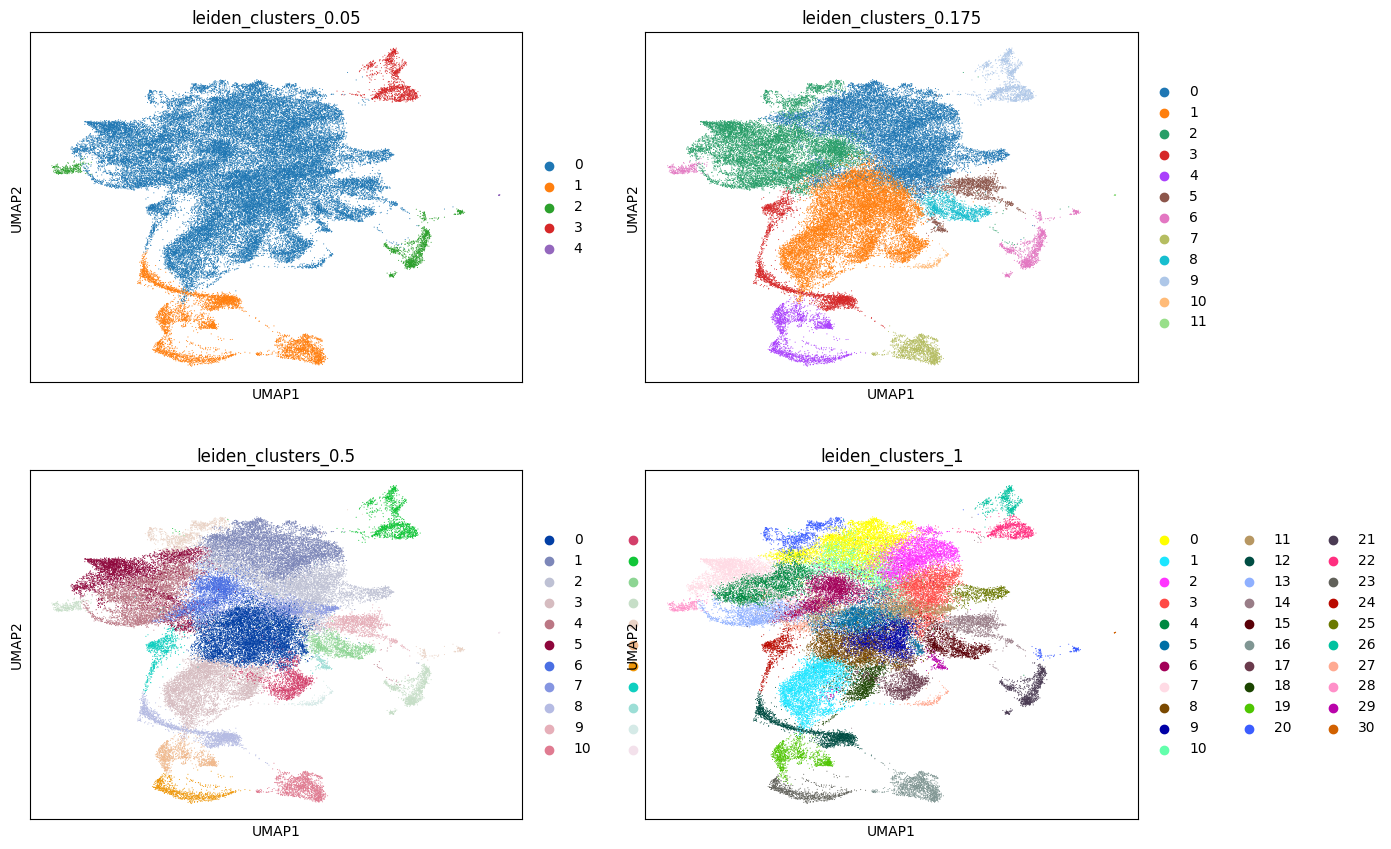

In [8]:
sc.pl.umap(adata, color=['leiden_clusters_0.05','leiden_clusters_0.175',  'leiden_clusters_0.5', 
                         'leiden_clusters_1'],ncols=2)

In [ ]:
meta_subset = adata.obs.filter(regex=("leiden_clusters_"))
meta_subset.to_csv("../../processed_data/metadata/20241025_epi_leiden_metadata.csv")

In [ ]:
sc.pp.filter_genes(adata, min_cells=10)

In [ ]:
pd.DataFrame(adata.obs_names).to_csv("../../processed_data/attributeName/cellName_epi.csv")
pd.DataFrame(adata.var_names).to_csv("../../processed_data/attributeName/varName_epi.csv")

In [ ]:
adata.write_h5ad("../../processed_data/integrated_data/20241024_epithelium.h5ad")